# Multi-City COVID-19 Model

In [1]:
using AlgebraicPetri
using AlgebraicPetri.Epidemiology

using Petri
using OrdinaryDiffEq
using Plots

using Catlab
using Catlab.Theories
using Catlab.Programs
using Catlab.CategoricalAlgebra.ShapeDiagrams
using Catlab.WiringDiagrams
using Catlab.Graphics

import Catlab.Theories: id

display_wd(ex) = to_graphviz(ex, orientation=LeftToRight, labels=true);
id(args...) = foldl((x,y)->id(x) ⊗ id(y), args);

#### Step 1: Define a new primitive to extend the presentation of InfectiousDiseases

In [2]:
travel_petri = PetriCospan(
        [1,2,3],
        Petri.Model(1:6, [(Dict(1=>1), Dict(4=>1)), (Dict(2=>1), Dict(5=>1)), (Dict(3=>1), Dict(6=>1))]),
        [4,5,6]);

#### Step 2: Extend the Infectious Disease presentation,
get the new generators, and update the functor

In [3]:
@present EpiWithTravel <: InfectiousDiseases begin
    travel::Hom(S⊗E⊗I,S⊗E⊗I)
end;

S,E,I,R,D,transmission,exposure,illness,recovery,death,travel = generators(EpiWithTravel);
new_functor = copy(FunctorGenerators)
new_functor[travel] = travel_petri

F(ex) = functor((PetriCospanOb, PetriCospan), ex, generators=new_functor);

### COVID-19 TRAVEL MODEL:

SEIRD City Model with travel as S ⊗ E ⊗ I → S ⊗ E ⊗ I

$seird_{city} = (((Δ(S) ⊗ id(E)) ⋅ (id(S) ⊗ σ(S,E))) ⊗ id(I)) ⋅ (id(S, E) ⊗ exposure) ⋅
                (id(S) ⊗ (∇(E) ⋅ Δ(E)) ⊗ id(I)) ⋅ (id(S, E) ⊗ ((illness ⊗ id(I)) ⋅
                (∇(I) ⋅ Δ(I)) ⋅ (id(I) ⊗ (Δ(I) ⋅(recovery ⊗ death))))) ⋅ (travel ⊗ ◊(R) ⊗ ◊(D))$

This is a very complicated interaction, so we can use the program interface for easier model definition

┌ Warning: `solve(ex)` is deprecated in JuliaVariables 0.2.x. Please use `solve!(ex)` instead.  `solve(ex)`, which currently mutates `ex` in-place, will be re-introduced in 0.3 as a non-mutating variant.
│   caller = mk_function(::Module, ::Expr) at GeneralizedGenerated.jl:22
└ @ GeneralizedGenerated /home/runner/.julia/packages/GeneralizedGenerated/IobaZ/src/GeneralizedGenerated.jl:22


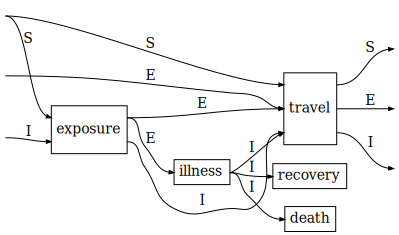

In [4]:
seird_city = @program EpiWithTravel (s::S, e::E, i::I) begin
    e2, i2 = exposure(s, i)
    i3 = illness(e2)
    d = death(i3)
    r = recovery(i3)
    return travel(s, [e, e2], [i2, i3])
end
seird_city = to_hom_expr(FreeBiproductCategory, seird_city)

display_wd(seird_city)

-

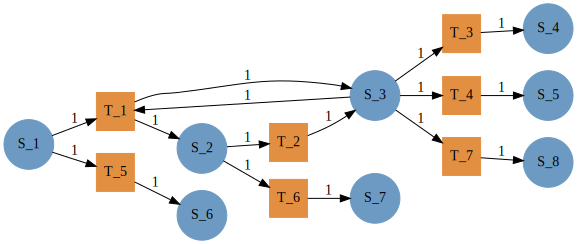

In [5]:
Graph(decoration(F(seird_city)))

create a multi-city SEIRD models

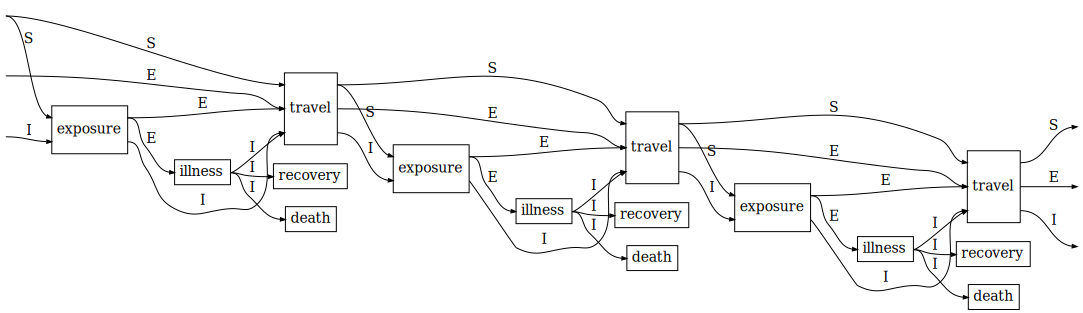

In [6]:
ncities(city,n::Int) = compose([city for i in 1:n]...)

seird_3 = ncities(seird_city, 3)
pc_seird_3 = F(seird_3)
p_seird_3 = decoration(pc_seird_3)
display_wd(seird_3)

-

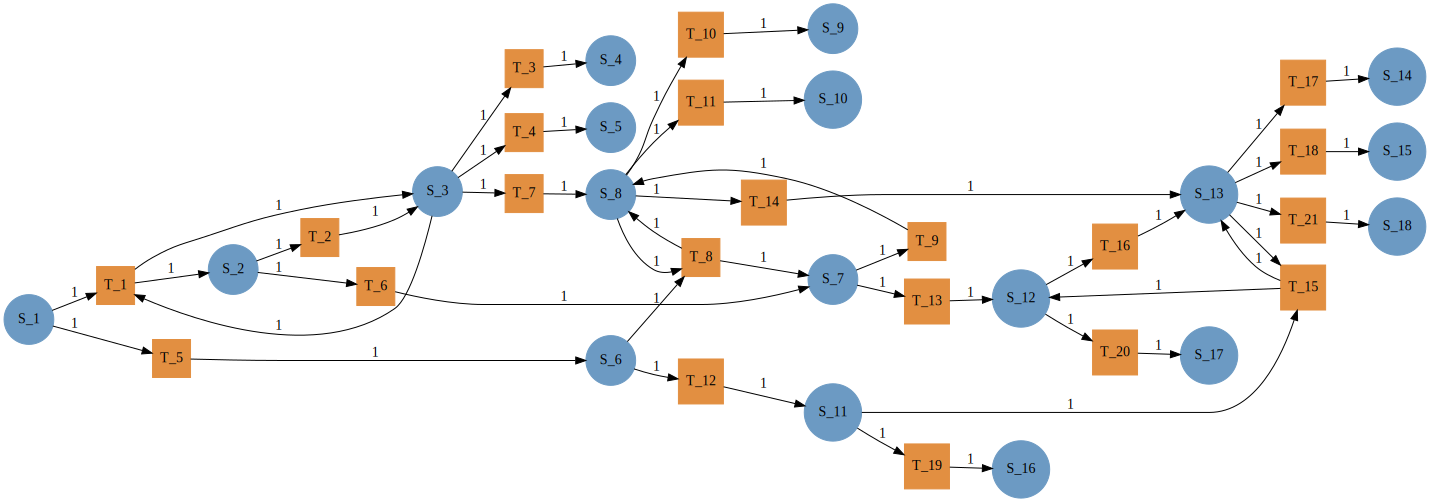

In [7]:
Graph(p_seird_3)

Define time frame and initial parameters

In [8]:
tspan = (0.0,90.0)
u0 = zeros(Float64, length(base(pc_seird_3)))
u0[1]  = 10000
u0[6]  = 10000
u0[11] = 10000
u0[2]  = 1

seirdparams(n::Int, k::Number) = begin
    βseird = [10/sum(u0), 1/2, 1/5, 1/16]
    βtravel = [1/20, 1/200, 1/20]/100k
    β = vcat(βseird, βtravel)
    return foldl(vcat, [(1-(0/(2n)))*β for i in 1:n])
end
params = seirdparams(3, 5);

Generate, solve, and visualize resulting ODE

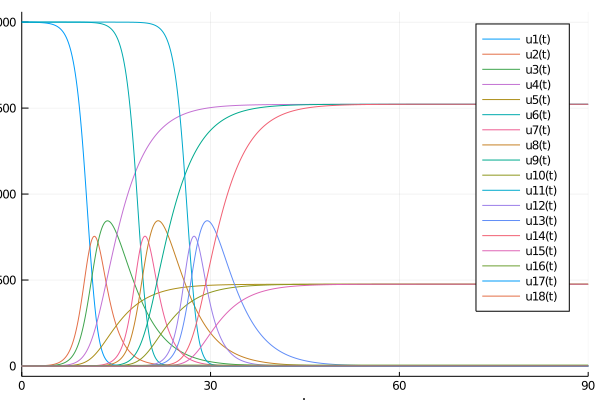

In [9]:
prob = ODEProblem(p_seird_3,u0,tspan,params);
sol = solve(prob,Tsit5());

plot(sol)

Define different dynamic transition function rates

In [10]:
asymptotic(a,b,k=1) = t->(b + (a-b)/(k*t+1))
triangleasm(a,b,k=1) = t->max(b, (1-t/k)*(a-b)+b)
trianglewave(a,b,k=1) = t->((a-b)/π)*asin(sin(t*2π/k))+2b
coswave(a,b,k=1) = t->(a-b)*(cos(t*2π/k)/2)+( a+b )/2
sincwave(a,b,k=1) = t->(a-b)*(sinc(t*2π/k)/2)+( a+b )/2
modsincwave(a,b,k) = t-> max(b, (a-b)*(sinc(t*2π/k))+(b))
dynseirdparams(f, a,b,period, n::Int, scale::Number) = begin
    βseird = [f(a,b,period), 1/2, 1/5, 1/16]
    βtravel = [1/20, 1/200, 1/20]/100scale
    β = vcat(βseird, βtravel)
    return foldl(vcat, [β for i in 1:n])
end

waveparams(f,a,b,p) = begin
    dynseirdparams(f,a,b,p,3,5)
end;

Generate, solve, and visualize ODE of a dynamic flow rates

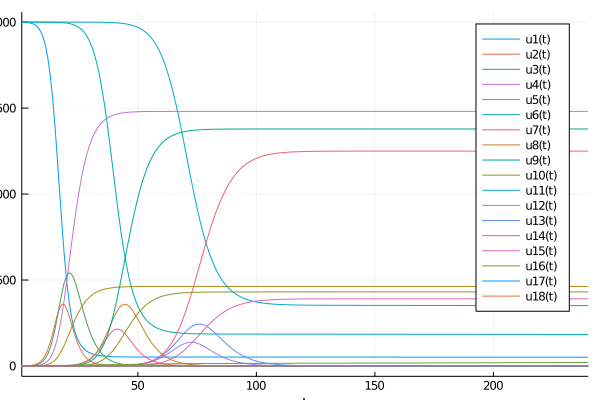

In [11]:
tspan = (0, 240.0)
a,b,p = 10, 1, 1/6

dynparams = waveparams(asymptotic, a/sum(u0), b/sum(u0),p)

prob = ODEProblem(p_seird_3,u0,tspan, dynparams)
sol = solve(prob,Tsit5(), saveat=1:1:tspan[2])

plot(sol)